In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Прогнозирование производственного брака

В настоящем проекте необходимо определить объем брака партии изделий по значениям множества признаков, описывающих производственный процесс. Целевой признак является бинарным, т.е. выделяется два класса: ***большой объем бракованных изделий в партии*** и ***малый объем бракованных изделий в партии***. Таким образом рассматриваемая задача является ***бинарной классификации*** и может быть решена с помощью ***алгоритма логистической регрессии***.

В качестве метрики выбрана ***f1-мера***, т.к. классы в рассматриваемом датасете являеютя несбалансированными.

## Датасет
Анализ проводился на основе следующего [датасета](https://www.kaggle.com/datasets/rabieelkharoua/predicting-manufacturing-defects-dataset).
Данный датасет включает в себя информацию по различным параметрам производства для партий изделий различного объема. Датасет содержит следующие поля признаков:

### Объем производства (ProductionVolume): Количество единиц, производимых в день.
- **Тип данных**: Integer (целое число).
- **Диапазон**: 100 до 1000 единиц/день.

### Затраты на производство (ProductionCost): Затраты на производство в день.
- **Тип данных**: Float (вещественное число).
- **Диапазон**: $5000 до $20000.

### Логистика и цепочка поставок (Supply Chain and Logistics)

#### Качество поставщиков (SupplierQuality): Оценка качества поставщиков.
- **Тип данных**: Float (%).
- **Диапазон**: 80% до 100%.

#### Задержка поставки (DeliveryDelay): Среднее время задержки поставки.
- **Тип данных**: Integer (целое число, дни).
- **Диапазон**: 0 до 5 дней.

### Контроль качества и уровень брака (Quality Control and Defect Rates)

#### Уровень брака (DefectRate): Количество брака на тысячу произведенных единиц.
- **Тип данных**: Float (вещественное число).
- **Диапазон**: 0.5 до 5.0 бракованных единиц.

#### Оценка качества (QualityScore): Общая оценка качества.
- **Тип данных**: Float (%).
- **Диапазон**: 60% до 100%.

### Обслуживание и время простоя (Maintenance and Downtime)

#### Часы на обслуживание (MaintenanceHours): Количество часов, потраченных на обслуживание в неделю.
- **Тип данных**: Integer (целое число).
- **Диапазон**: 0 до 24 часов.

#### Процент простоя (DowntimePercentage): Процент времени простоя производства.
- **Тип данных**: Float (%).
- **Диапазон**: 0% до 5%.

### Управление запасами (Inventory Management)

#### Оборачиваемость запасов (InventoryTurnover): Коэффициент оборачиваемости запасов.
- **Тип данных**: Float (вещественное число).
- **Диапазон**: 2 до 10 дней.

#### Частота нехватки запасов (StockoutRate): Частота нехватки запасов.
- **Тип данных**: Float (%).
- **Диапазон**: 0% до 10%.

### Производительность и безопасность персонала (Workforce Productivity and Safety)

#### Производительность персонала (WorkerProductivity): Уровень производительности рабочей силы.
- **Тип данных**: Float (%).
- **Диапазон**: 80% до 100%.

#### Инциденты безопасности (SafetyIncidents): Количество инцидентов безопасности в месяц.
- **Тип данных**: Integer (целое число).
- **Диапазон**: 0 до 10 инцидентов.

### Потребление и эффективность энергии (Energy Consumption and Efficiency)

#### Потребление энергии (EnergyConsumption): Потребление энергии в кВт⋅ч.
- **Тип данных**: Float (вещественное число).
- **Диапазон**: 1000 до 5000 кВт⋅ч.

#### Эффективность использования энергии (EnergyEfficiency): Коэффициент эффективности использования энергии.
- **Тип данных**: Float (вещественное число).
- **Диапазон**: 0.1 до 0.5.

### Аддитивное производство (Additive Manufacturing)

#### Время процесса аддитивного производства (AdditiveProcessTime): Время, затраченное на аддитивное производство.
- **Тип данных**: Float (часы).
- **Диапазон**: 1 до 10 часов.

#### Стоимость аддитивных материалов (AdditiveMaterialCost): Стоимость аддитивных материалов на единицу.
- **Тип данных**: Float ($).
- **Диапазон**: $100 до $500.

### Целевая переменная (Target Variable)

#### Статус брака (DefectStatus): Прогнозируемый статус брака.
- **Тип данных**: Binary (0 для низкого уровня брака, 1 для высокого уровня брака).

### Знакомство с данными
Устанавливаем необходимые модули, подавляем вывод, чтобы не загромождать ноутбук.

In [3]:
%%capture
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install xgboost
%pip install graphviz

Игнорируем предупреждения в выводе команд.

In [4]:
import warnings
warnings.filterwarnings('ignore')

Импортируем необходимые нам модули и классы.

In [43]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.cbook import boxplot_stats

from xgboost import XGBClassifier
from graphviz import Source


from sklearn.tree import export_graphviz
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score, 
    train_test_split,
    GridSearchCV
)
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report
)

Загружаем данные из заранее скачанного файла в формате CSV.

In [6]:
DATA_PATH = "manufacturing_defect_dataset.csv"

data = pd.read_csv(DATA_PATH)
data.head()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
0,202,13175.403783,86.648534,1,3.121492,63.463494,9,0.052343,8.630515,0.081322,85.042379,0,2419.616785,0.468947,5.551639,236.439301,1
1,535,19770.046093,86.310664,4,0.819531,83.697818,20,4.908328,9.296598,0.038486,99.657443,7,3915.566713,0.119485,9.080754,353.957631,1
2,960,19060.820997,82.132472,0,4.514504,90.350550,1,2.464923,5.097486,0.002887,92.819264,2,3392.385362,0.496392,6.562827,396.189402,1
3,370,5647.606037,87.335966,5,0.638524,67.628690,8,4.692476,3.577616,0.055331,96.887013,8,4652.400275,0.183125,8.097496,164.135870,1
4,206,7472.222236,81.989893,3,3.867784,82.728334,9,2.746726,6.851709,0.068047,88.315554,7,1581.630332,0.263507,6.406154,365.708964,1


Рассмотрим основную информацию о датасете. В датасете содерижтся 3240 строк с данными, 17 колонок, 5 из которых относятся к целому типу, 12 -- к вещественному.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3240 entries, 0 to 3239
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ProductionVolume      3240 non-null   int64  
 1   ProductionCost        3240 non-null   float64
 2   SupplierQuality       3240 non-null   float64
 3   DeliveryDelay         3240 non-null   int64  
 4   DefectRate            3240 non-null   float64
 5   QualityScore          3240 non-null   float64
 6   MaintenanceHours      3240 non-null   int64  
 7   DowntimePercentage    3240 non-null   float64
 8   InventoryTurnover     3240 non-null   float64
 9   StockoutRate          3240 non-null   float64
 10  WorkerProductivity    3240 non-null   float64
 11  SafetyIncidents       3240 non-null   int64  
 12  EnergyConsumption     3240 non-null   float64
 13  EnergyEfficiency      3240 non-null   float64
 14  AdditiveProcessTime   3240 non-null   float64
 15  AdditiveMaterialCost 

Проверим наличие пропусков в данных, пропуски отсутствуют.

In [8]:
data.isna().sum()

ProductionVolume        0
ProductionCost          0
SupplierQuality         0
DeliveryDelay           0
DefectRate              0
QualityScore            0
MaintenanceHours        0
DowntimePercentage      0
InventoryTurnover       0
StockoutRate            0
WorkerProductivity      0
SafetyIncidents         0
EnergyConsumption       0
EnergyEfficiency        0
AdditiveProcessTime     0
AdditiveMaterialCost    0
DefectStatus            0
dtype: int64

Проверим наличие дубликатов строк, дубликатов не обнаружено.

In [9]:
data.duplicated().sum()

np.int64(0)

Определим количество уникальных значений по столбцам. Для большинства столбцов все значения являются уникальными.

In [10]:
for col in data.columns:
        print(f"{col}: {data[col].nunique()}")

ProductionVolume: 862
ProductionCost: 3240
SupplierQuality: 3240
DeliveryDelay: 6
DefectRate: 3240
QualityScore: 3240
MaintenanceHours: 24
DowntimePercentage: 3240
InventoryTurnover: 3240
StockoutRate: 3240
WorkerProductivity: 3240
SafetyIncidents: 10
EnergyConsumption: 3240
EnergyEfficiency: 3240
AdditiveProcessTime: 3240
AdditiveMaterialCost: 3240
DefectStatus: 2


Рассмотрим основные параметры данных по столбцам.

In [11]:
data.describe()

,ProductionVolume,ProductionCost,SupplierQuality,DeliveryDelay,DefectRate,QualityScore,MaintenanceHours,DowntimePercentage,InventoryTurnover,StockoutRate,WorkerProductivity,SafetyIncidents,EnergyConsumption,EnergyEfficiency,AdditiveProcessTime,AdditiveMaterialCost,DefectStatus
count,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000,3240.000000
mean,548.523148,12423.018476,89.833290,2.558951,2.749116,80.134272,11.476543,2.501373,6.019662,0.050878,90.040115,4.591667,2988.494453,0.299776,5.472098,299.515479,0.840432
std,262.402073,4308.051904,5.759143,1.705804,1.310154,11.611750,6.872684,1.443684,2.329791,0.028797,5.723600,2.896313,1153.420820,0.116400,2.598212,116.379905,0.366261
min,100.000000,5000.174521,80.004820,0.000000,0.500710,60.010098,0.000000,0.001665,2.001611,0.000002,80.004960,0.000000,1000.720156,0.100238,1.000151,100.211137,0.000000
25%,322.000000,8728.829280,84.869219,1.000000,1.598033,70.103420,5.750000,1.264597,3.983249,0.026200,85.180203,2.000000,1988.140273,0.200502,3.228507,194.922058,1.000000
50%,549.000000,12405.204656,89.704861,3.000000,2.708775,80.265312,12.000000,2.465151,6.022389,0.051837,90.125743,5.000000,2996.822301,0.297470,5.437134,299.728918,1.000000
75%,775.250000,16124.462428,94.789936,4.000000,3.904533,90.353822,17.000000,3.774861,8.050222,0.075473,95.050838,7.000000,3984.788299,0.402659,7.741006,403.178283,1.000000
max,999.000000,19993.365549,99.989214,5.000000,4.998529,99.996993,23.000000,4.997591,9.998577,0.099997,99.996786,9.000000,4997.074741,0.499500,9.999749,499.982782,1.000000


Для единообразия приведем все столбцы к вещественному типу.

In [12]:
columns2float64 = [
    "ProductionVolume",
    "DeliveryDelay",
    "MaintenanceHours",
    "SafetyIncidents",
    "DefectStatus"
]

for column in columns2float64:
    data[column] = data[column].astype(float)

data.dtypes

ProductionVolume        float64
ProductionCost          float64
SupplierQuality         float64
DeliveryDelay           float64
DefectRate              float64
QualityScore            float64
MaintenanceHours        float64
DowntimePercentage      float64
InventoryTurnover       float64
StockoutRate            float64
WorkerProductivity      float64
SafetyIncidents         float64
EnergyConsumption       float64
EnergyEfficiency        float64
AdditiveProcessTime     float64
AdditiveMaterialCost    float64
DefectStatus            float64
dtype: object

## Визуализация данных

Изучим матрицу корреляции признаков. Из матрицы видно, что отстуствует какая-то корреляция между признаками, явная зависимость есть только между некоторыми принзнаками и целевой переменной. Рассмотрим эти признаки. Наблюдается положительная корреляция между объемом производства (`ProductionVolume`) и количетством брака. Действительно, чем больше ежедневный выпуск продукции, тем больше процент брака, это обычная практика для массового производства. Например, на сложных производствах таких, как изготовления микроэлектроники, процент брака может быть больше 50%. Также есть явная положительная корреляция производвтвенного брака с временм технического обслуживания (`MaintenanceHours`). Это можно объяснить тем, что если потребовалось техническое обслуживание, особенно продолжительно, то была остановка производства, что неминуемо привело к появлению брака. Также можно отметить отрицательную корреляцию с общей оценкой качетства производства (`QualityScore`), так как высокая оценка качества в том числе включает в себя объем брака в партии. Также присутствует очевидная положительная корреляция с количеством брака на тысячу произведенных единиц продукции (`DefectRate`), которая является производной целевого показателя.

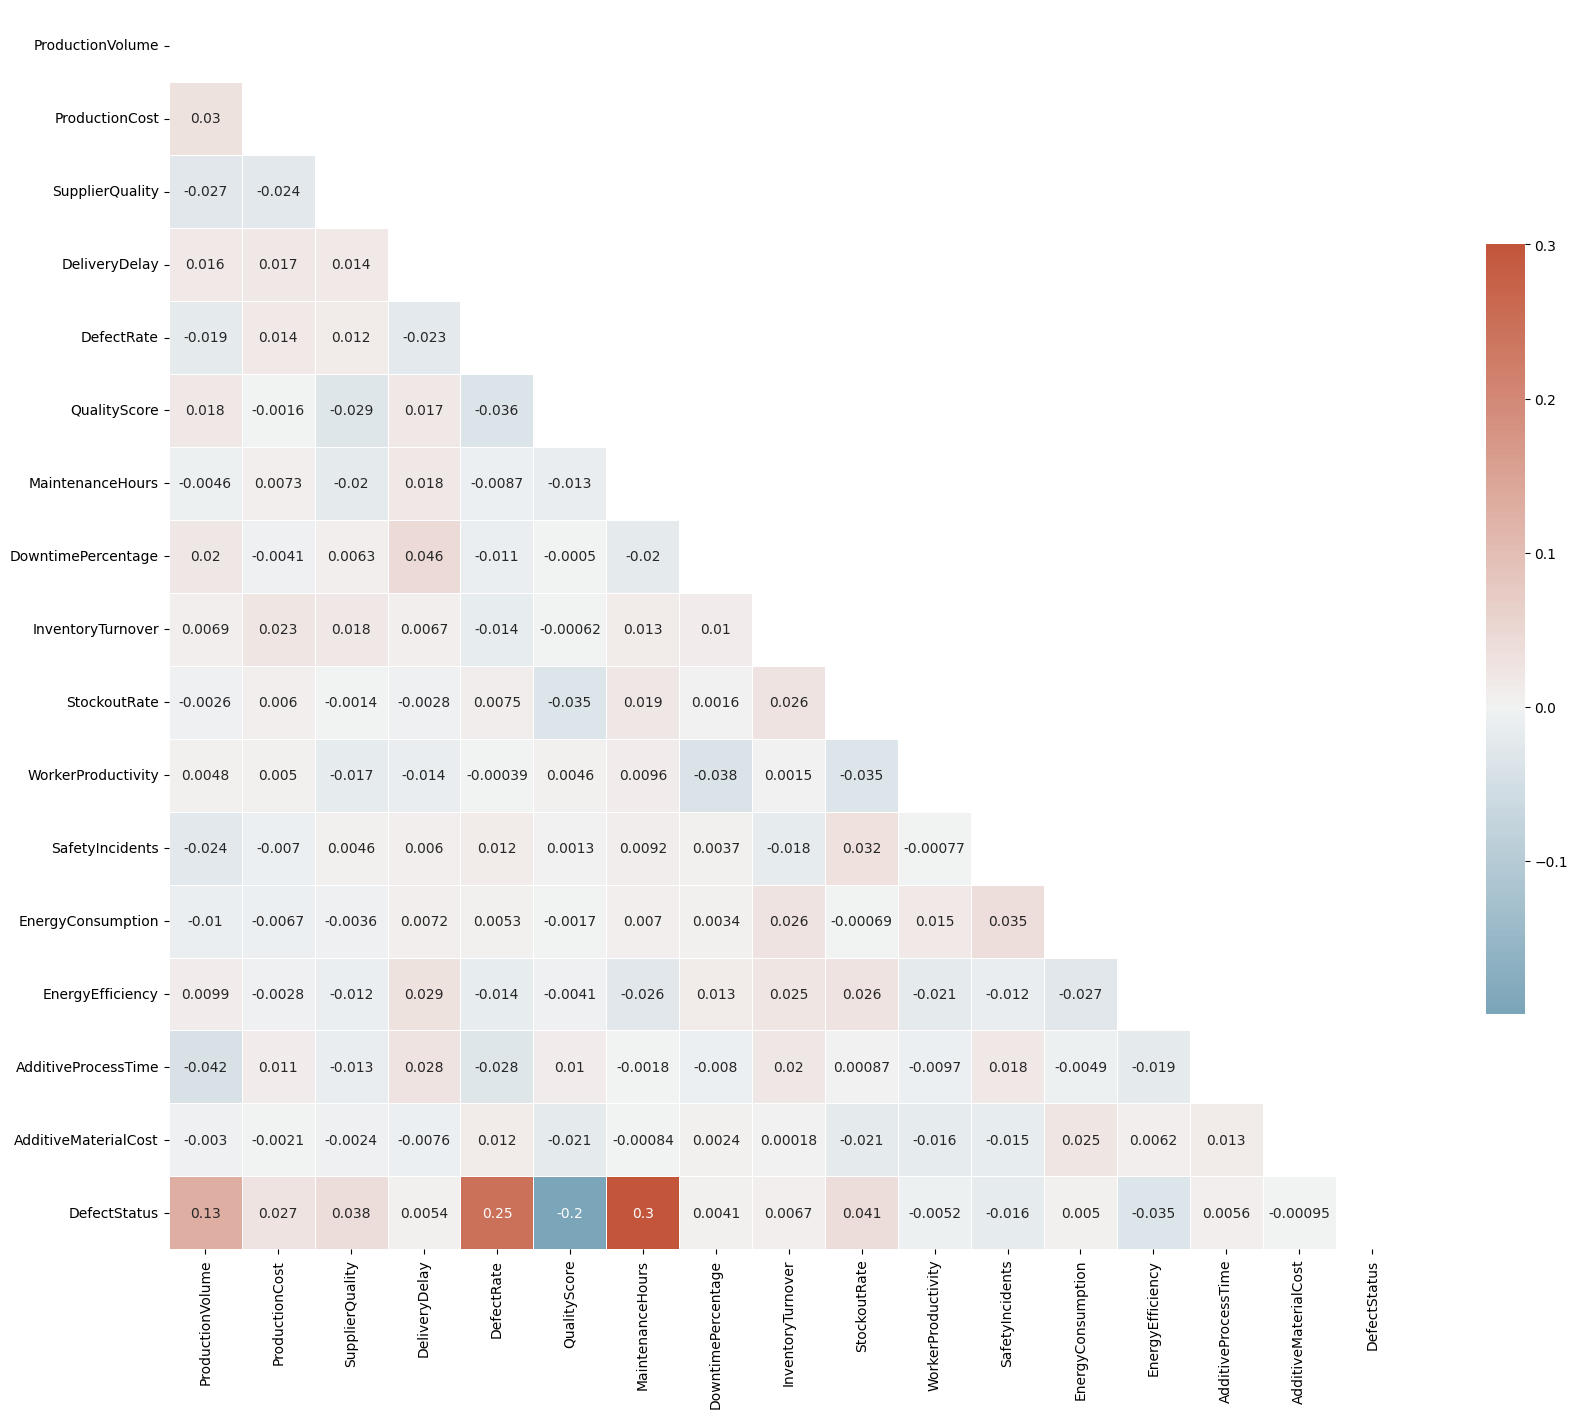

In [13]:

corr = data.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=.3,
    center=0,
    square=True, 
    linewidths=.5,
    annot=True,
    cbar_kws={"shrink": .5}
);

Рассмотрим количество партий с большим и малым количеством брака в процентном и натуральном выражении. Как уже отмечалось ранее, при достаточно больших объемах производства, брак неизбежен, особенно для выпуска высокотехнологичной продукции. Также стоит отметить несбалансированность классов с перекосом в сторону партиий с большим количеством брака.

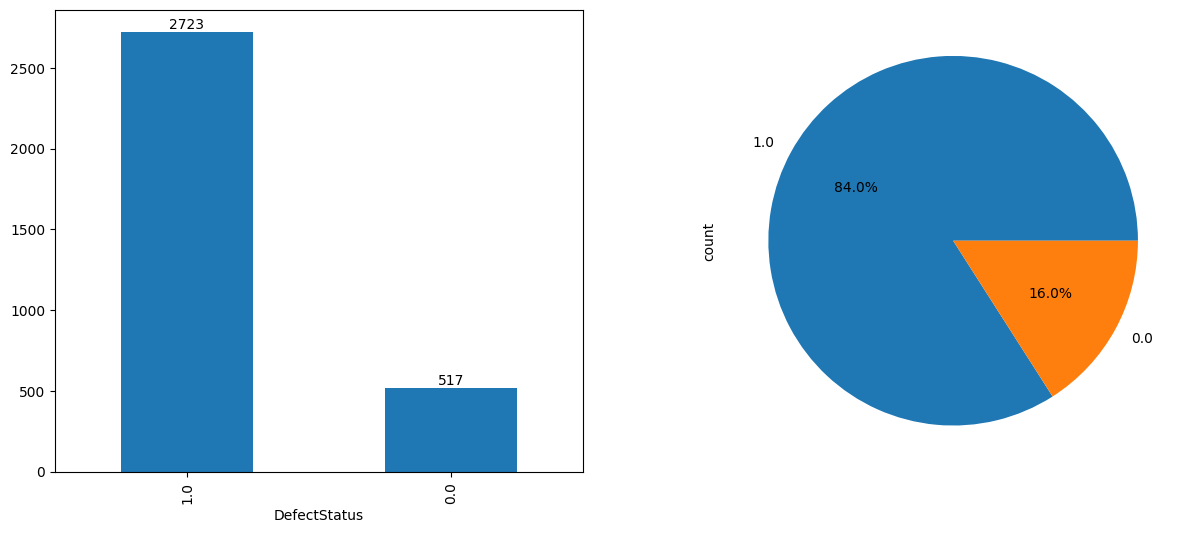

In [14]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
index = 0

count = data["DefectStatus"].value_counts()
count.plot(kind="bar", ax=axes[index])
for container in axes[index].containers:
    axes[index].bar_label(container)

index += 1

count.plot(kind="pie", ax=axes[index], autopct="%0.1f%%");

Рассмотрим более подробно влияние распределения признаков на целевую переменную, а также наличие выбросов. Из графиков и статистической информации видно, что есть незначительное количество выбросов, которыми можно принебречь. Соответственно, дополнительная очистка данных не требуется.

Feature DefectRate has 13 outliers: [4.78964685 4.70085941 4.85898311 4.74878464 4.87422034 4.87516911
 4.73548788 4.76090329 4.76252162 4.79369177 4.95709579 4.80437487
 4.96766508]
Feature MaintenanceHours has 21 outliers: [23. 23. 23. 20. 23. 19. 22. 19. 22. 21. 22. 21. 22. 20. 19. 22. 19. 19.
 20. 23. 19.]


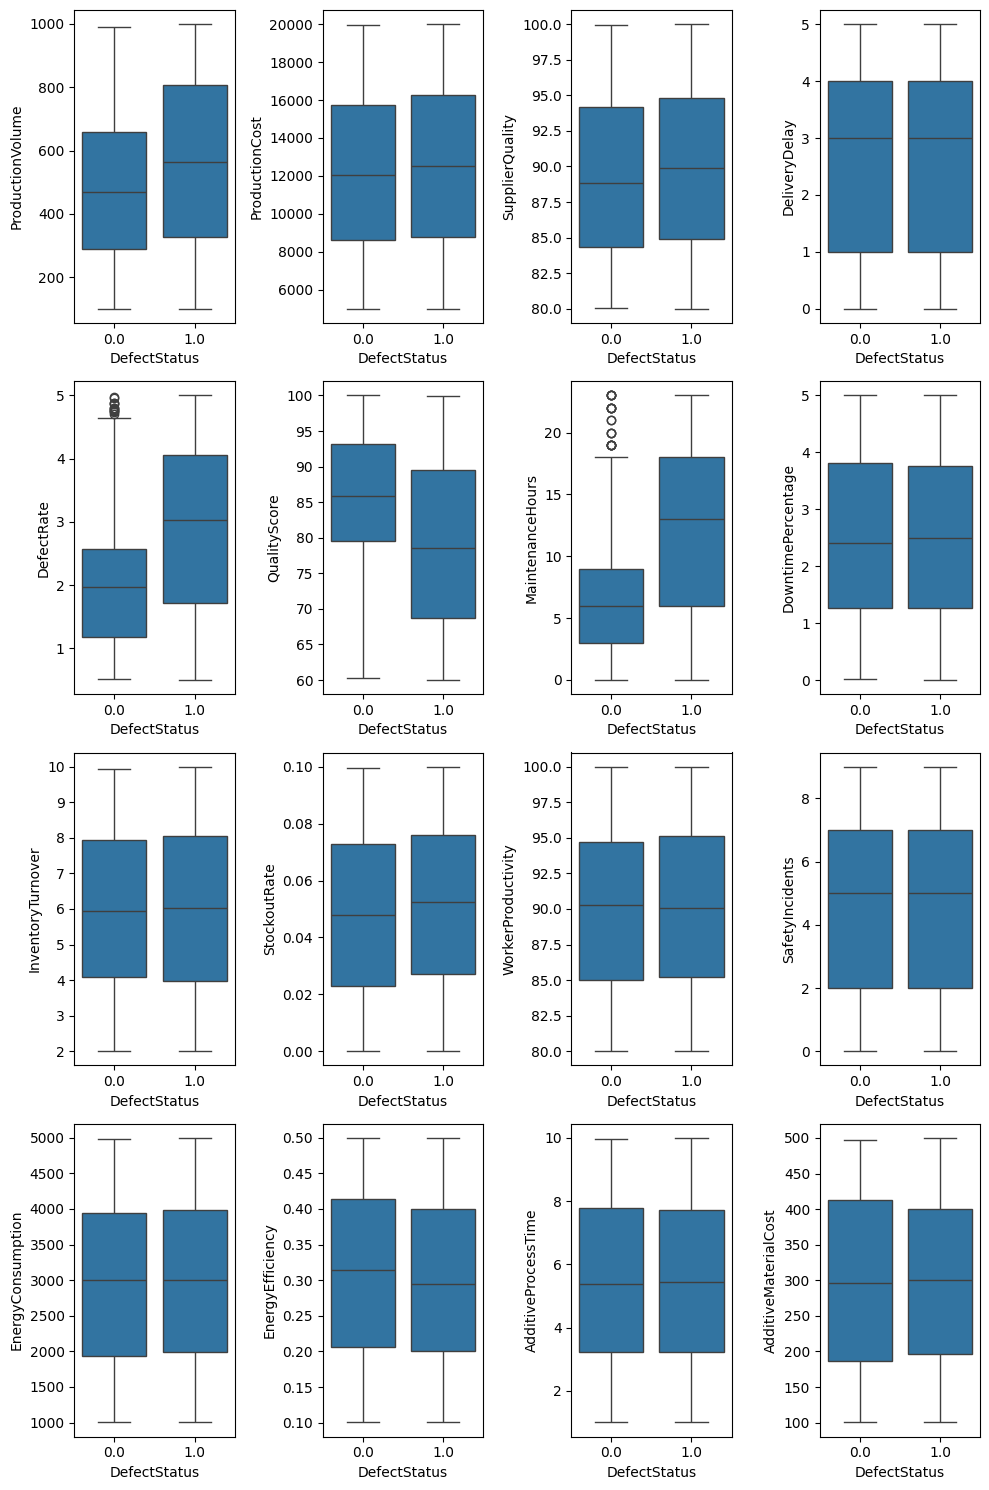

In [15]:
excluded_features  = ["DefectStatus"]
fig, ax = plt.subplots(4, 4, figsize=(10, 15))
df_iter = iter(data)

try:
    for j in range(len(ax)):
        for i in range(len(ax[j])):
            feature = next(df_iter)
            if feature not in excluded_features:
                ax[j][i] = sns.boxplot(
                    data=data, 
                    y=feature, 
                    x="DefectStatus",
                    ax=ax[j][i]
                )
                outliers = boxplot_stats(data.loc[data["DefectStatus"] == 0, [feature]]).pop(0)["fliers"]
                if outliers.size != 0:
                    print(f"Feature {feature} has {len(outliers)} outliers: {outliers}")
    fig.tight_layout()
except StopIteration:
    pass

Рассмотрим более подробно влияние различных значений признаков на целевую перменную. В целом, графики полностью подтверждают высказанные ранее гипотезы.

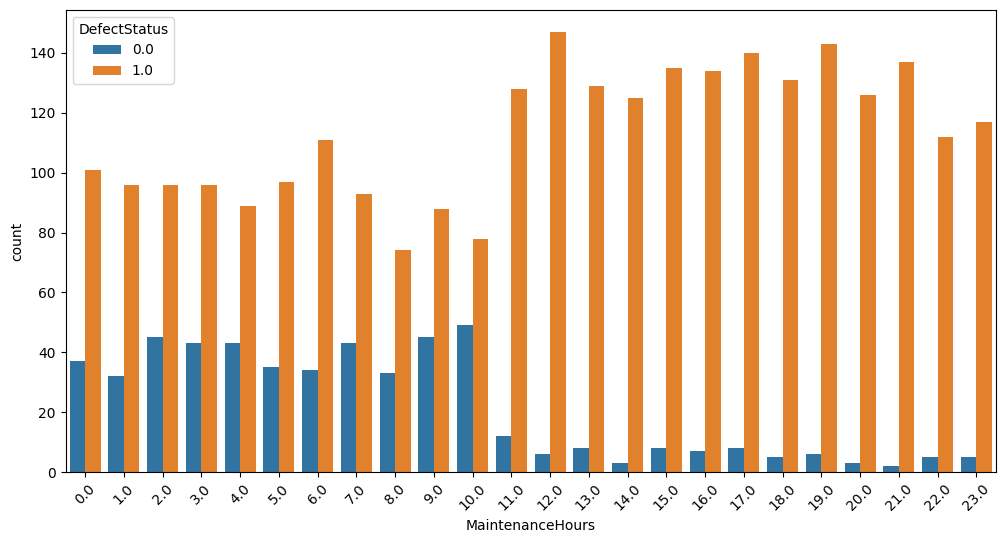

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x="MaintenanceHours", hue="DefectStatus", data=data)
ax.tick_params(axis='x', labelrotation=45);

Признаки `ProductionVolume`, `DefectRate` и `QualityScore` являются непрывными величинами, поэтому для наглядного отображения зависимости предварительно необходимо разделить пространство величин на дискретные интервалы (бины).

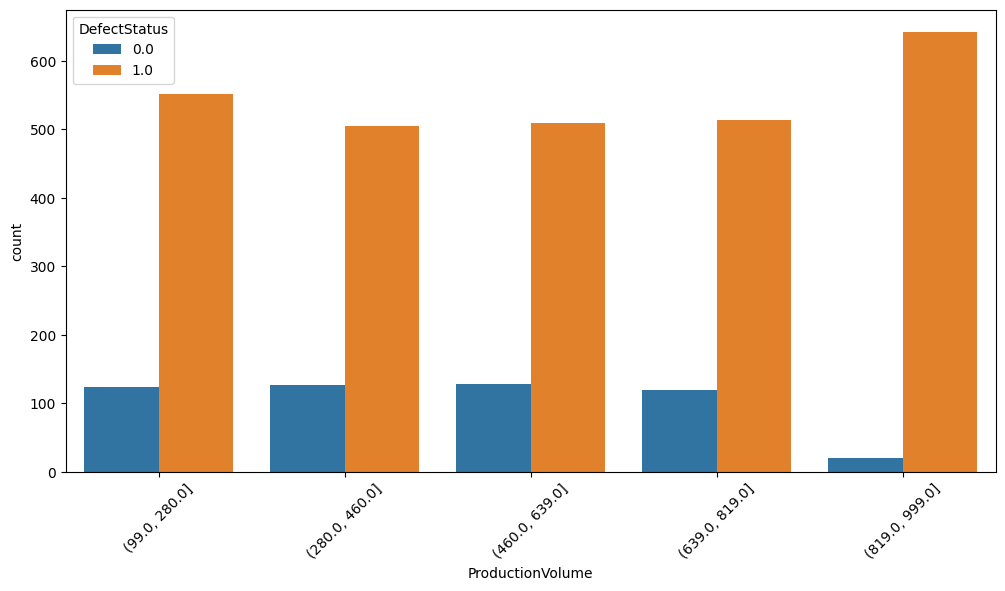

In [17]:
prod_vol_bins = pd.cut(data["ProductionVolume"], bins=5, precision=0)

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=prod_vol_bins, hue="DefectStatus", data=data)
ax.tick_params(axis='x', labelrotation=45);

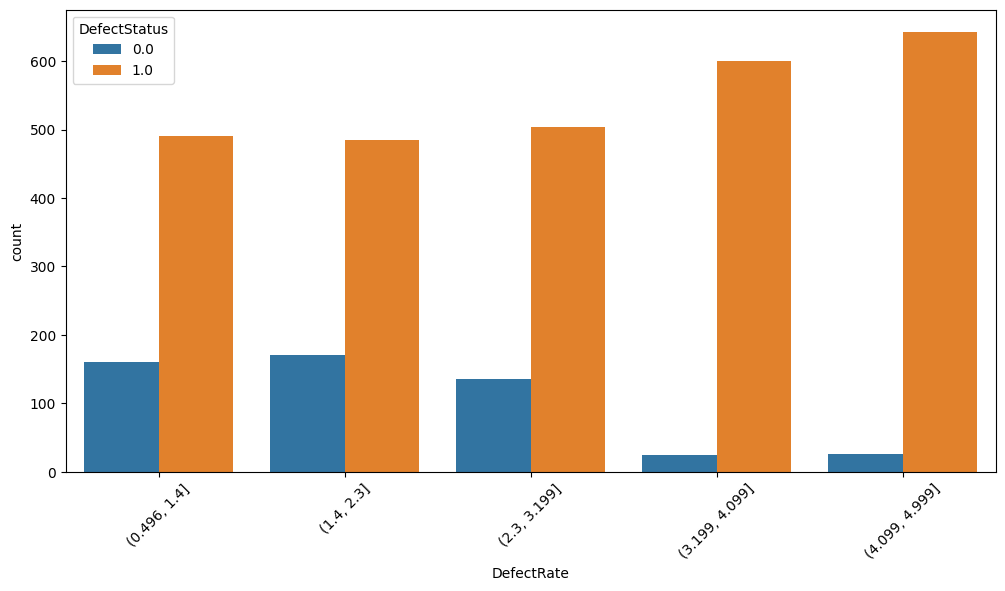

In [18]:

defect_rate_bins = pd.cut(data["DefectRate"], bins=5)

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=defect_rate_bins, hue="DefectStatus", data=data)
ax.tick_params(axis='x', labelrotation=45);

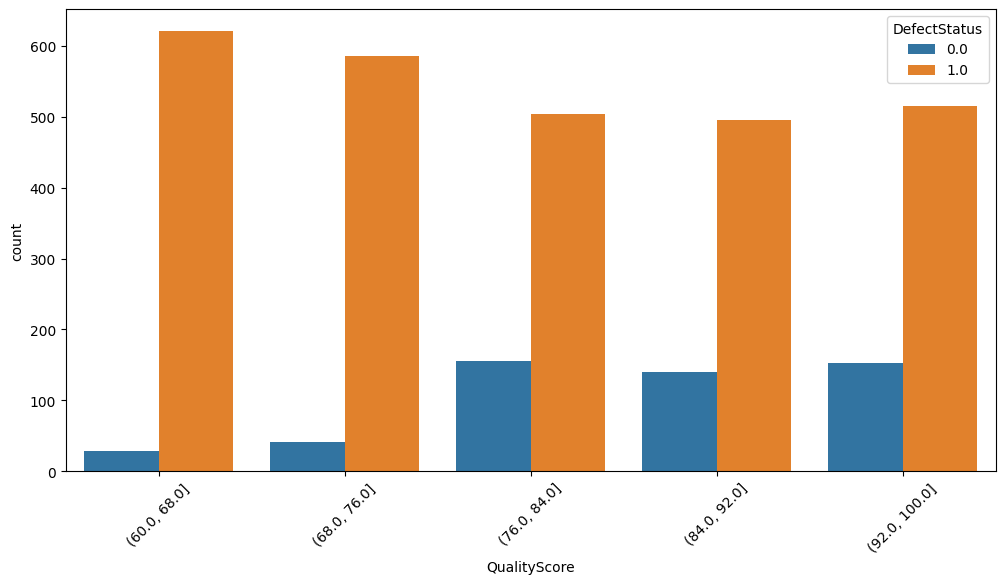

In [19]:
quality_scorel_bins = pd.cut(data["QualityScore"], bins=5, precision=0)

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=quality_scorel_bins, hue="DefectStatus", data=data)
ax.tick_params(axis='x', labelrotation=45);

Сделаем обучающую, валидационную и тестовую выборки.

In [20]:
target_column = data["DefectStatus"]
data = data.drop(["DefectStatus"], axis=1) # Признаки.
data_train, data_test, target_train, target_test = train_test_split(
    data, 
    target_column, 
    random_state=2024, 
    test_size=0.25, 
    stratify=target_column
)

Масштабирование признаков

In [21]:
scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

## Бейзлайн

Реализуем простейший классификатор, выдающий наиболее часто встречающийся результат в выборке. Обучим классификатор.

In [22]:
dummy_clsf = DummyClassifier(strategy="most_frequent")
dummy_clsf.fit(data_train, target_train)
target_predict_dummy = dummy_clsf.predict(data_test)

DummyClassifier(strategy='most_frequent')

Также реализуем классификатор на основе логистической регрессии. Изменим параметры штрафа и решатель, потому что на стандартных значениях решение не сходится даже при значительном увеличении количества итераций. Обучим классификатор.

In [23]:
logreg_clsf = LogisticRegression(penalty="l1", solver='liblinear')
logreg_clsf.fit(data_train, target_train)

LogisticRegression(penalty='l1', solver='liblinear')

Определим качество бейзлайн модели по метрике ***f1-мера***.

In [24]:
target_predict_dummy = dummy_clsf.predict(data_test)
f1_score(target_test, target_predict_dummy)

np.float64(0.9134808853118712)

Сделаем то же самое для логистической регрессии.

In [25]:
target_predict_logreg = logreg_clsf.predict(data_test)
f1_score(target_test, target_predict_logreg)

np.float64(0.9338959212376934)

Выполним проверку с кросс-валидацией. Результат показывает, что значение, полученное кросс-валидацией, меньше, чем полученное на тестовой выборке (0.926 < 0.934).

In [26]:
logreg_clsf = LogisticRegression(penalty='l1', solver='liblinear')
scores = cross_val_score(
    logreg_clsf, 
    data_train, 
    target_train, 
    cv=10, 
    scoring="f1"
)
scores
scores.mean()

array([0.91725768, 0.9255814 , 0.92523364, 0.92307692, 0.92807425,
       0.93023256, 0.9212963 , 0.92271663, 0.93488372, 0.93176471])

np.float64(0.9260117801323455)

Выбор модели: **Случайный лес**

In [27]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=468)
rf_model.fit(data_train, target_train)

target_predict_rf = rf_model.predict(data_test)

rf_accuracy = accuracy_score(target_test, target_predict_rf)
rf_f1 = f1_score(target_test, target_predict_rf)

print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_rf))

RandomForestClassifier(random_state=468)

Random Forest Model Performance:
Accuracy: 0.9679
F1 Score: 0.9812

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89       129
         1.0       0.97      1.00      0.98       681

    accuracy                           0.97       810
   macro avg       0.97      0.91      0.94       810
weighted avg       0.97      0.97      0.97       810



Выбор модели: **Градиентный бустинг**

XGBoost может быть более эффективным для задач, где требуется максимальная точность, особенно на дисбалансных данных.

Фреймворк **sklearn** модуль **GradientBoostingClassifier**

In [28]:
gb_model = GradientBoostingClassifier(random_state=863, n_estimators=100, learning_rate=0.1)
gb_model.fit(data_train, target_train)

target_predict_gb = gb_model.predict(data_test)

gb_accuracy = accuracy_score(target_test, target_predict_gb)
gb_f1 = f1_score(target_test, target_predict_gb)

print("GradientBoostingClassifier Model Performance:")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"F1 Score: {gb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_gb))

GradientBoostingClassifier(random_state=863)

GradientBoostingClassifier Model Performance:
Accuracy: 0.9654
F1 Score: 0.9797

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       129
         1.0       0.97      0.99      0.98       681

    accuracy                           0.97       810
   macro avg       0.96      0.90      0.93       810
weighted avg       0.97      0.97      0.96       810



Бибилиотека **xgboost**

In [29]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=777)
xgb_model.fit(data_train, target_train)

target_predict_xgd = xgb_model.predict(data_test)

xgb_accuracy = accuracy_score(target_test, target_predict_xgd)
xgb_f1 = f1_score(target_test, target_predict_xgd)

print("XGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_xgd))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=777, ...)

XGBoost Model Performance:
Accuracy: 0.9605
F1 Score: 0.9768

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.81      0.87       129
         1.0       0.96      0.99      0.98       681

    accuracy                           0.96       810
   macro avg       0.95      0.90      0.92       810
weighted avg       0.96      0.96      0.96       810



Подбор гиперпараметров с использованием кросс-валидации для случайного леса

In [30]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 400],
    "max_depth": [None, 10, 20, 30, 40],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8]
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(data_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

Обучение с найденными гиперпараметрами, значение f1 не изменилось

In [31]:
rf_model = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=20,
    n_estimators=300
)
rf_model.fit(data_train, target_train)

target_predict_rf = rf_model.predict(data_test)

rf_accuracy = accuracy_score(target_test, target_predict_rf)
rf_f1 = f1_score(target_test, target_predict_rf)

print("Random Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_rf))

RandomForestClassifier(min_samples_split=20, n_estimators=300)

Random Forest Model Performance:
Accuracy: 0.9679
F1 Score: 0.9812

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89       129
         1.0       0.97      1.00      0.98       681

    accuracy                           0.97       810
   macro avg       0.97      0.91      0.94       810
weighted avg       0.97      0.97      0.97       810



Подбор гиперпараметров для модели градиентного бустинга GradientBoostingClassifier

In [32]:
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(data_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

Обучение с найденными гиперпараметрами, значение тоже f1 не изменилось

In [33]:
gb_model = GradientBoostingClassifier(
    max_depth=10,
    min_samples_leaf=4,
    min_samples_split=2,
    n_estimators=300
)
gb_model.fit(data_train, target_train)

target_predict_gb = gb_model.predict(data_test)

gb_accuracy = accuracy_score(target_test, target_predict_gb)
gb_f1 = f1_score(target_test, target_predict_gb)

print("GradientBoostingClassifier Model Performance:")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"F1 Score: {gb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_gb))

GradientBoostingClassifier(max_depth=10, min_samples_leaf=4, n_estimators=300)

GradientBoostingClassifier Model Performance:
Accuracy: 0.9654
F1 Score: 0.9797

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88       129
         1.0       0.97      0.99      0.98       681

    accuracy                           0.97       810
   macro avg       0.96      0.90      0.93       810
weighted avg       0.97      0.97      0.96       810



Подбор гиперпараметров для модели градиентного бустинга xgboost

In [34]:
param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    verbose=1,
    n_jobs=-1
)

grid_search.fit(data_train, target_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Accuracy:", best_score)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=777, ...),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='f1', verbose=1)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9745457288802155


Применение подобранных гиперпараметров дало незначительное увеличение метрики 0.9768 < 0.9790, но сама библиотека работает просто на порядки быстрее. Если бы мне подошел градиентсный бустинг, я бы использовал именно ее

In [35]:
xgb_model = XGBClassifier(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=100
)
xgb_model.fit(data_train, target_train)

target_predict_xgd = xgb_model.predict(data_test)

xgb_accuracy = accuracy_score(target_test, target_predict_xgd)
xgb_f1 = f1_score(target_test, target_predict_xgd)

print("XGBoost Model Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(target_test, target_predict_xgd))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, min_samples_leaf=1, min_samples_split=2,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=100, n_jobs=None, ...)

XGBoost Model Performance:
Accuracy: 0.9642
F1 Score: 0.9790

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88       129
         1.0       0.97      0.99      0.98       681

    accuracy                           0.96       810
   macro avg       0.96      0.90      0.93       810
weighted avg       0.96      0.96      0.96       810



Определим важность признаков

In [36]:
feature_importances = rf_model.feature_importances_
features = data.columns

И отсортируем признаки по степени важности

In [37]:
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = features[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

Гистрограмма распределения признаков по степени важности, в целом видно, что это те признаки, у которых есть корреляция

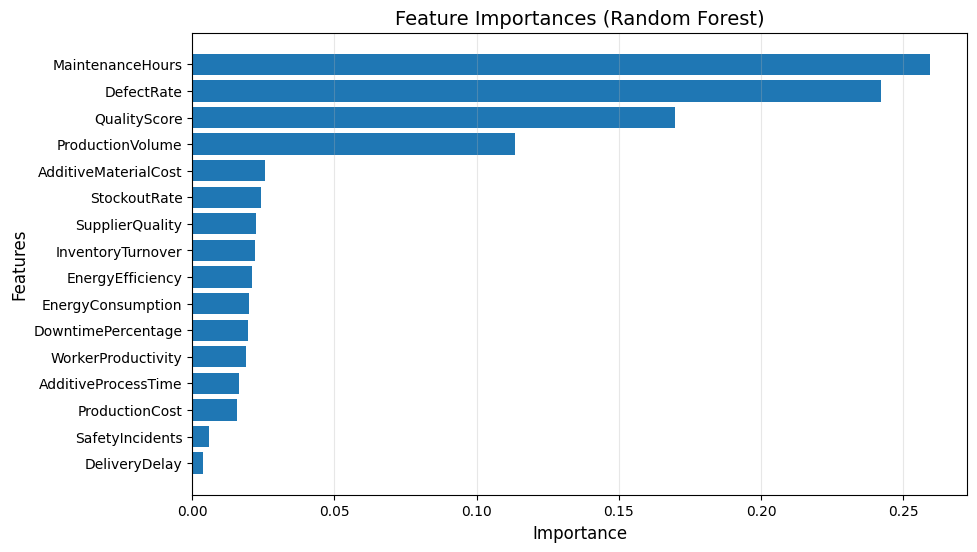

In [38]:
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, align='center')
plt.gca().invert_yaxis()
plt.title('Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show();

То же самое для степени важности перестановок

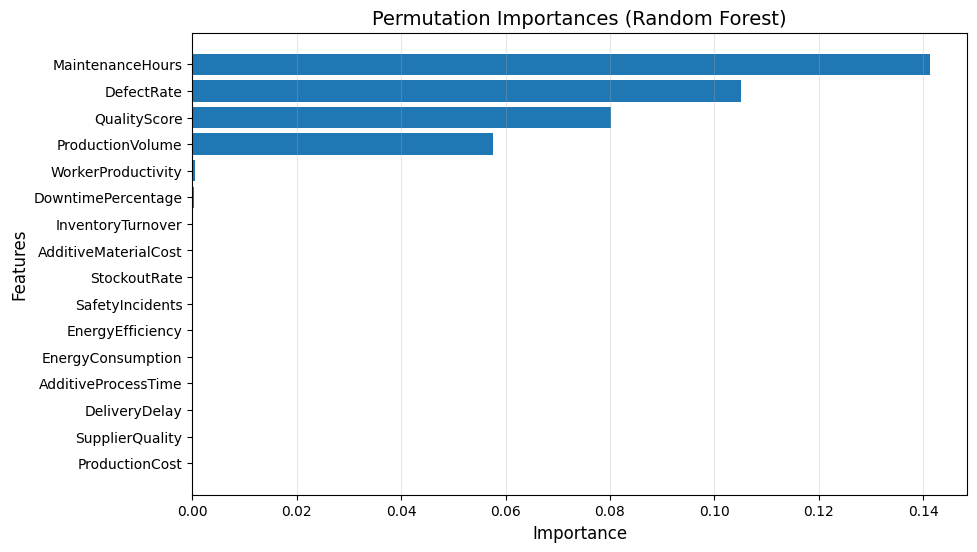

In [39]:
perm_importance = permutation_importance(rf_model, data_test, target_test, n_repeats=10, random_state=42)
perm_sorted_indices = perm_importance.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.barh(features[perm_sorted_indices], perm_importance.importances_mean[perm_sorted_indices], align='center')
plt.gca().invert_yaxis()
plt.title('Permutation Importances (Random Forest)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.show();

Визуализируем одно из деревьев решений

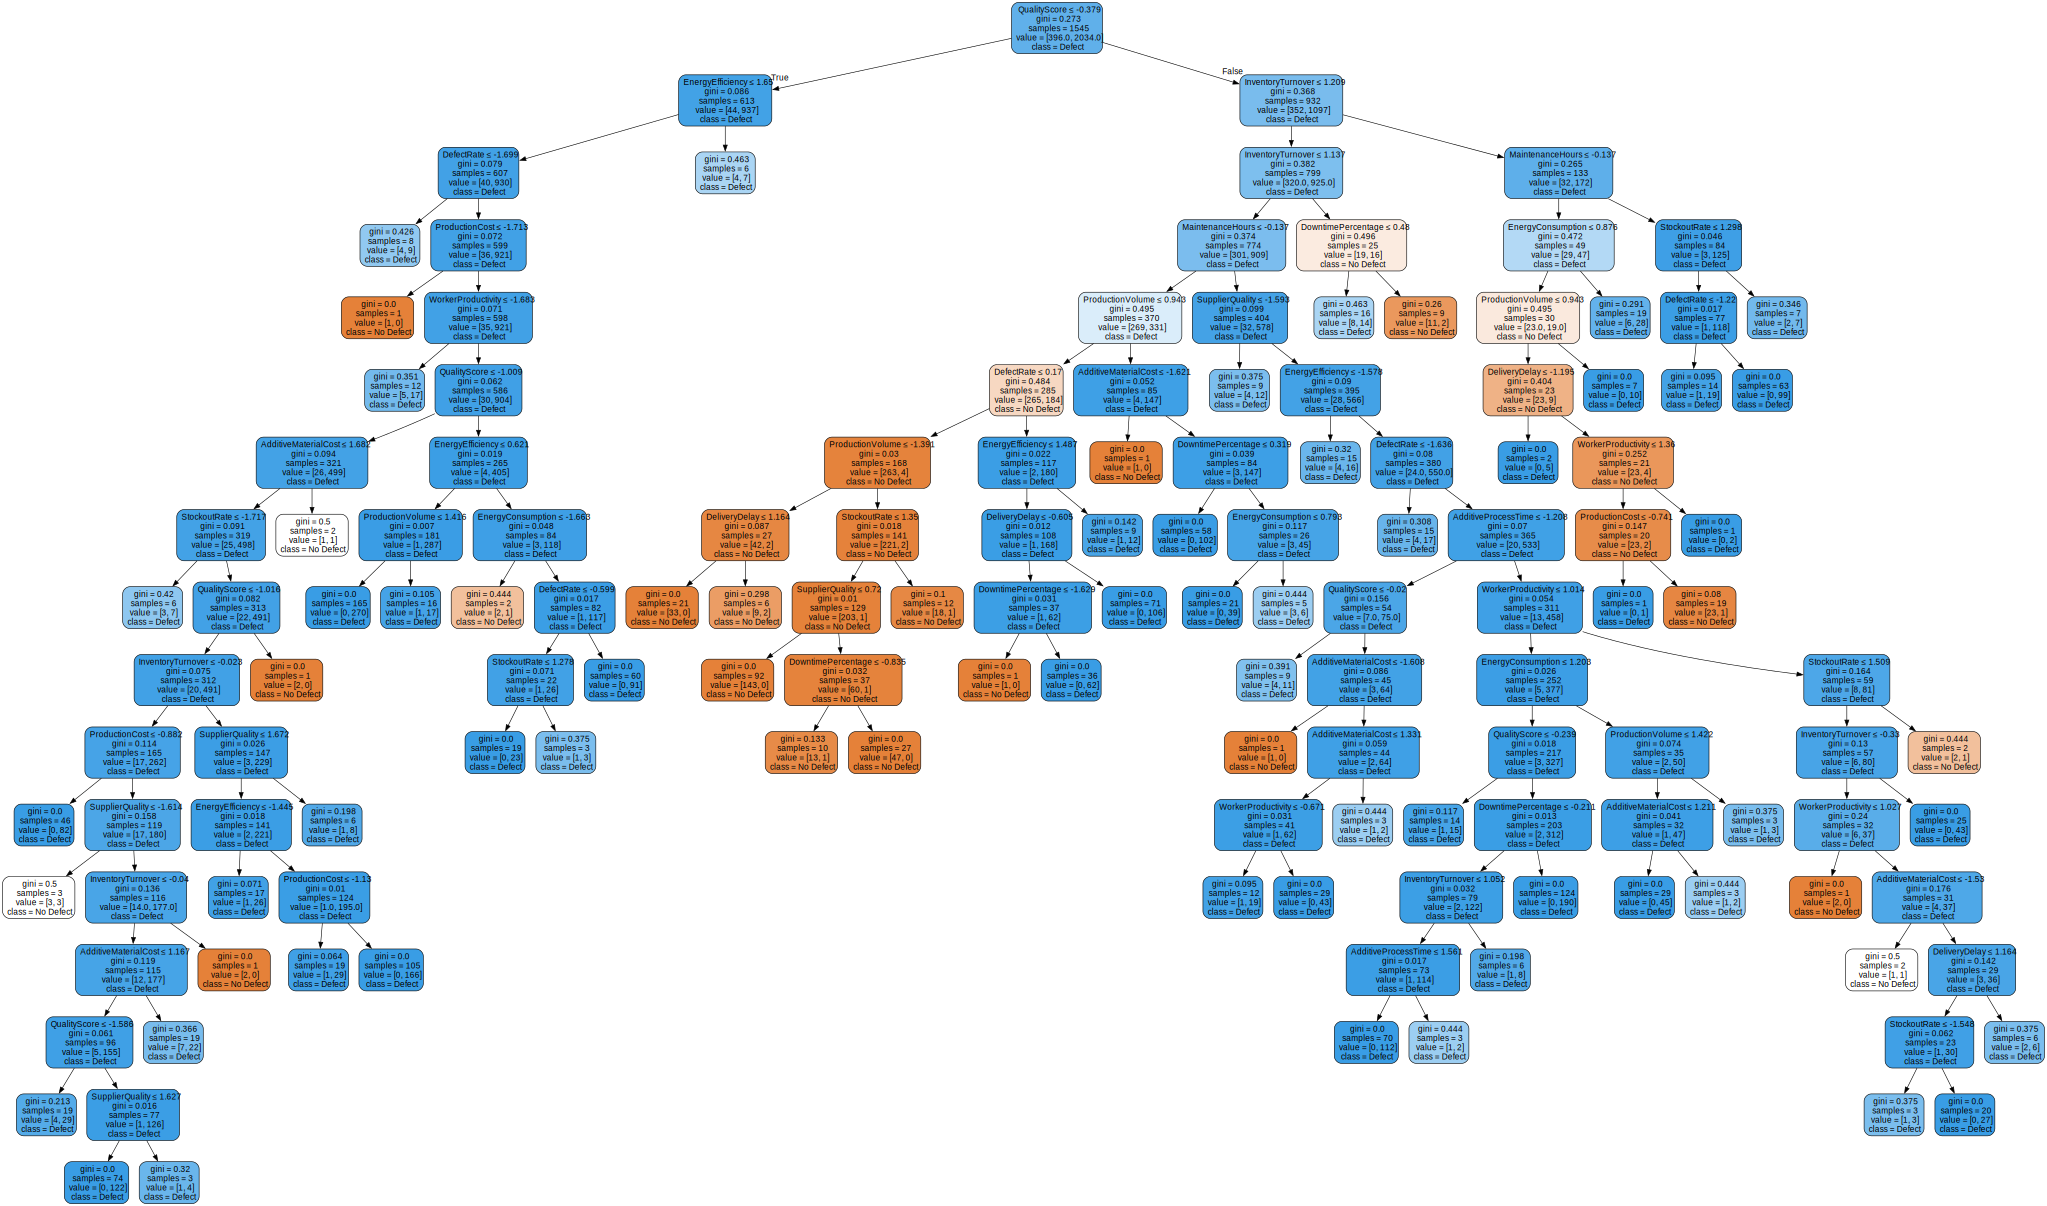

In [40]:
os.environ["PATH"] += os.pathsep + "C:\Program Files\Graphviz\bin"

# Экспорт одного дерева из случайного леса
tree_dot = export_graphviz(
    rf_model.estimators_[0],
    feature_names=features,
    class_names=["No Defect", "Defect"],
    rounded=True,
    filled=True,
    special_characters=True
)

# Визуализация с помощью Graphviz
graph = Source(tree_dot)
graph

Наиболее важные факторы:

- QualityScore: Оценка качества, наиболее значимый фактор.

- ProductionVolume: Объем производства, важен для определения уровня дефектов.

- SupplierQuality: Качество поставщиков, сильно влияет на дефекты.

- MaintenanceHours: Часы на обслуживание, отражает состояние оборудования.

- DowntimePercentage: Процент простоя, связанный с производственными проблемами.

Выбор топ-4 признаков

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='MaintenanceHours', ylabel='DefectRate'>

Text(0.5, 1.0, 'Defect Rate vs MaintenanceHours')

Text(0.5, 0, 'MaintenanceHours')

Text(0, 0.5, 'Defect Rate')

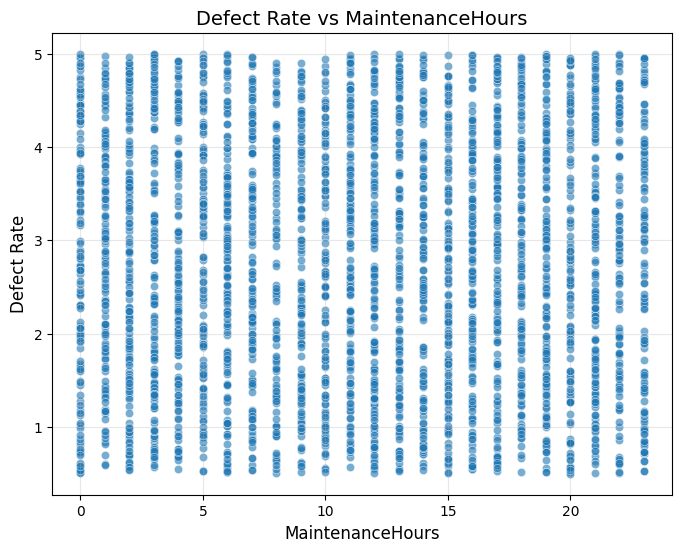

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='DefectRate', ylabel='DefectRate'>

Text(0.5, 1.0, 'Defect Rate vs DefectRate')

Text(0.5, 0, 'DefectRate')

Text(0, 0.5, 'Defect Rate')

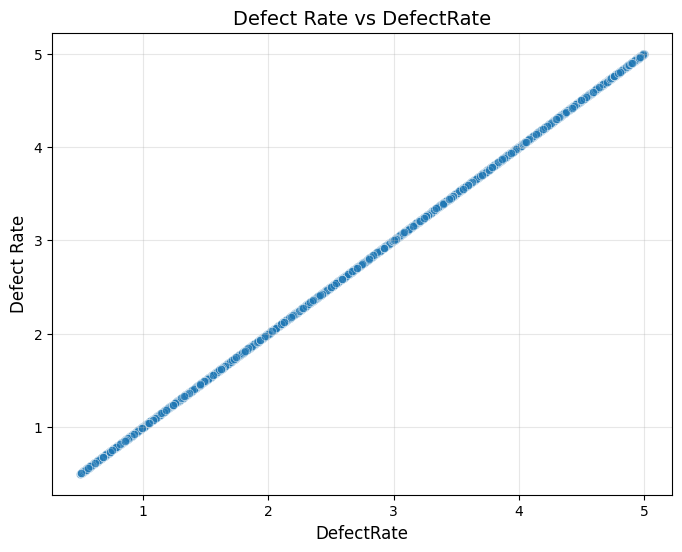

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='QualityScore', ylabel='DefectRate'>

Text(0.5, 1.0, 'Defect Rate vs QualityScore')

Text(0.5, 0, 'QualityScore')

Text(0, 0.5, 'Defect Rate')

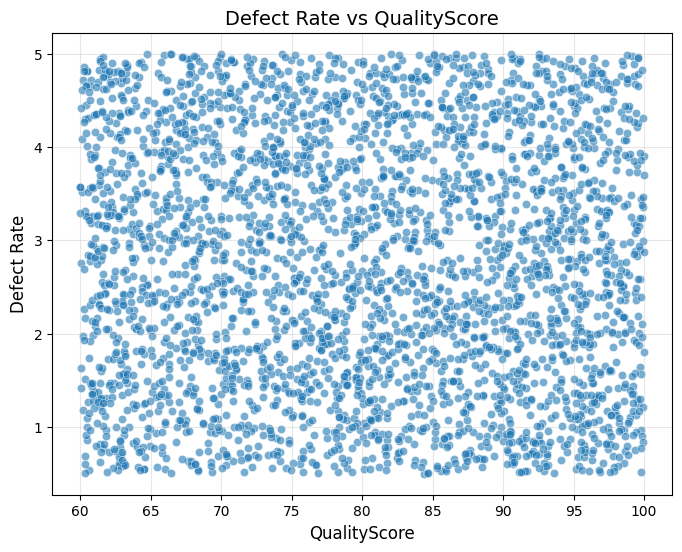

<Figure size 800x600 with 0 Axes>

<Axes: xlabel='ProductionVolume', ylabel='DefectRate'>

Text(0.5, 1.0, 'Defect Rate vs ProductionVolume')

Text(0.5, 0, 'ProductionVolume')

Text(0, 0.5, 'Defect Rate')

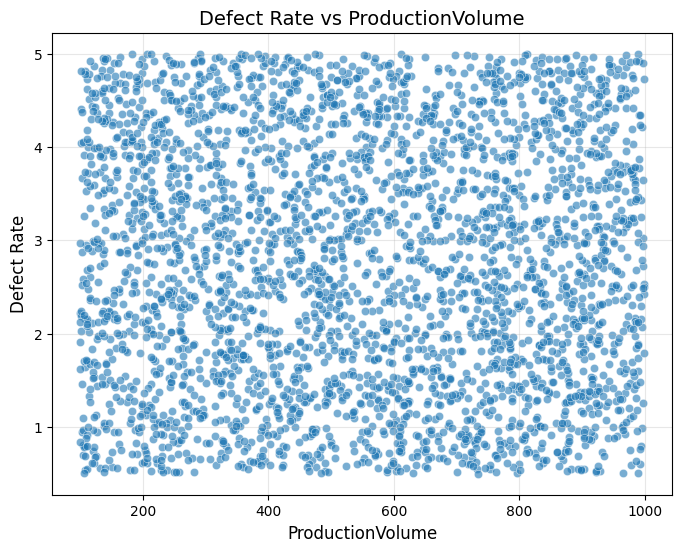

In [41]:
top_features = sorted_features[:4]  # Топ-4 признаков

# Построение графиков
for feature in top_features:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x=feature, y="DefectRate", alpha=0.6)
    plt.title(f'Defect Rate vs {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel("Defect Rate", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

# Выводы

В целом, решения, полученные моделью являются адекватными, признаки тоже выбраны верно. Как я уже отмечал, датасет демонстрирует реальное положение дел в серийном производстве, где по даже с учетом принципа полной взаимозаменяемости и грамотного расчета размерных цепей, брак неизбежен. И чем больше серия, тем больше процент брака. В классичеческой литературе по технологии приборостроения данные параметры рассчитваются, распредление брака по партиям можно более или менее прогнозировать, но с применением машинного обучения точность подобных оценок может быть существенно увеличена.